In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_parquet("../data/green_tripdata_2021-01.parquet")

In [3]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [4]:
data.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

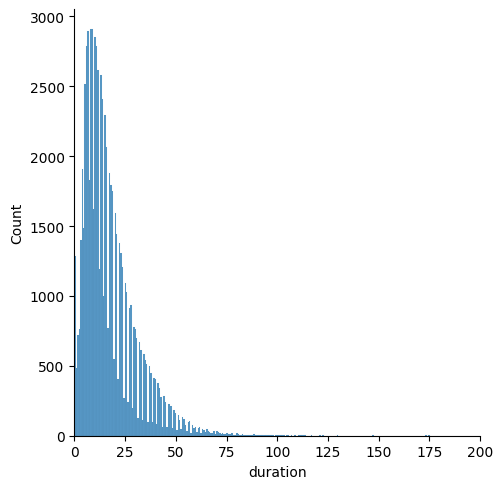

In [5]:
data['duration'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']
data['duration'] = data['duration'].apply(lambda x: x.total_seconds() / 60)
sns.displot(data['duration'])
plt.xlim(0, 200)
plt.show()

In [6]:
data['duration'].describe(percentiles=[0.02, 0.80, 0.90, 0.95, 0.98])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
2%           1.016667
50%         13.883333
80%         26.000000
90%         35.000000
95%         44.000000
98%         56.000000
max       1439.600000
Name: duration, dtype: float64

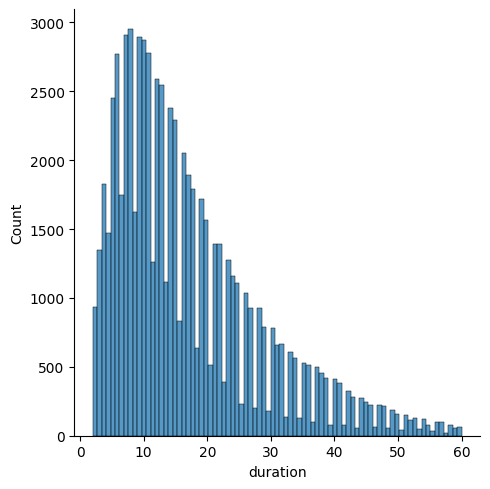

In [7]:
data = data[(data.duration >= 2) & (data.duration <= 60)]
sns.displot(data['duration'])

In [8]:
categorical = ['trip_type', 'PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = ['duration']
data = data[numerical + categorical + target]
data.head()

,trip_distance,trip_type,PULocationID,DOLocationID,duration
0,1.01,1.0,43,151,3.933333
1,2.53,1.0,166,239,8.750000
2,1.12,1.0,41,42,5.966667
3,1.99,1.0,168,75,7.083333
7,0.45,1.0,75,75,2.316667


In [9]:
print(data.dtypes, data.shape)

trip_distance    float64
trip_type        float64
PULocationID       int64
DOLocationID       int64
duration         float64
dtype: object (73203, 5)


In [10]:
data.trip_type.notnull().sum()
data.trip_type.mode()
data['trip_type'].fillna(1.0, inplace=True)

/tmp/ipykernel_1964/3838672903.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['trip_type'].fillna(1.0, inplace=True)


In [11]:
taxi_zones = pd.read_csv("../data/taxi_zone_lookup_coordinates.csv")
taxi_zones

,LocationID,Borough,Zone,service_zone,latitude,longitude
0,1,EWR,Newark Airport,EWR,40.692880,-74.185450
1,2,Queens,Jamaica Bay,Boro Zone,40.605700,-73.871300
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,40.865210,-73.843555
3,4,Manhattan,Alphabet City,Yellow Zone,40.725990,-73.980570
4,5,Staten Island,Arden Heights,Boro Zone,40.556400,-74.173500
...,...,...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone,40.711800,-74.013100
261,262,Manhattan,Yorkville East,Yellow Zone,40.769559,-73.941380
262,263,Manhattan,Yorkville West,Yellow Zone,40.771200,-73.949500
263,264,Unknown,NV,NaN,NaN,-116.655436


In [12]:
data = pd.merge(data, taxi_zones[['LocationID', 'latitude', 'longitude']], left_on='PULocationID', right_on='LocationID', how='left').rename(columns={"latitude": "PULat",
                                                                                                                                                   "longitude": "PULon"})

In [13]:
data = pd.merge(data, taxi_zones[['LocationID', 'latitude', 'longitude']], left_on='DOLocationID', right_on='LocationID', how='left').rename(columns={"latitude": "DOLat",
                                                                                                                                                   "longitude": "DOLon"})

In [14]:
data = data.drop(columns=["PULocationID", "DOLocationID", "LocationID_x", "LocationID_y"])
data

,trip_distance,trip_type,duration,PULat,PULon,DOLat,DOLon
0,1.01,1.0,3.933333,40.767480,-73.970690,40.797045,-73.969725
1,2.53,1.0,8.750000,40.810000,-73.962500,40.787000,-73.975400
2,1.12,1.0,5.966667,40.808900,-73.948200,40.798700,-73.952300
3,1.99,1.0,7.083333,40.814212,-73.924875,40.795000,-73.939000
4,0.45,1.0,2.316667,40.795000,-73.939000,40.795000,-73.939000
...,...,...,...,...,...,...,...
73198,17.63,1.0,38.000000,40.956410,-73.815330,40.740100,-73.990300
73199,18.36,1.0,38.000000,40.665200,-73.912500,40.817744,-73.862292
73200,2.50,1.0,11.000000,40.795000,-73.939000,40.833180,-73.913990
73201,14.48,1.0,27.000000,40.814212,-73.924875,40.680940,-73.790890


In [15]:
data["PULat"].fillna(data["PULat"].mean(), inplace=True)
data["PULon"].fillna(data["PULon"].mean(), inplace=True)
data["DOLat"].fillna(data["DOLat"].mean(), inplace=True)
data["DOLon"].fillna(data["DOLon"].mean(), inplace=True)
data

/tmp/ipykernel_1964/889112929.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["PULat"].fillna(data["PULat"].mean(), inplace=True)
/tmp/ipykernel_1964/889112929.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

,trip_distance,trip_type,duration,PULat,PULon,DOLat,DOLon
0,1.01,1.0,3.933333,40.767480,-73.970690,40.797045,-73.969725
1,2.53,1.0,8.750000,40.810000,-73.962500,40.787000,-73.975400
2,1.12,1.0,5.966667,40.808900,-73.948200,40.798700,-73.952300
3,1.99,1.0,7.083333,40.814212,-73.924875,40.795000,-73.939000
4,0.45,1.0,2.316667,40.795000,-73.939000,40.795000,-73.939000
...,...,...,...,...,...,...,...
73198,17.63,1.0,38.000000,40.956410,-73.815330,40.740100,-73.990300
73199,18.36,1.0,38.000000,40.665200,-73.912500,40.817744,-73.862292
73200,2.50,1.0,11.000000,40.795000,-73.939000,40.833180,-73.913990
73201,14.48,1.0,27.000000,40.814212,-73.924875,40.680940,-73.790890


In [16]:
onehot = pd.get_dummies(data['trip_type'], prefix="triptype").map(lambda x: 1 if x else 0)
data = data.join(onehot).drop(columns=['trip_type'])

In [17]:
data

,trip_distance,duration,PULat,PULon,DOLat,DOLon,triptype_1.0,triptype_2.0
0,1.01,3.933333,40.767480,-73.970690,40.797045,-73.969725,1,0
1,2.53,8.750000,40.810000,-73.962500,40.787000,-73.975400,1,0
2,1.12,5.966667,40.808900,-73.948200,40.798700,-73.952300,1,0
3,1.99,7.083333,40.814212,-73.924875,40.795000,-73.939000,1,0
4,0.45,2.316667,40.795000,-73.939000,40.795000,-73.939000,1,0
...,...,...,...,...,...,...,...,...
73198,17.63,38.000000,40.956410,-73.815330,40.740100,-73.990300,1,0
73199,18.36,38.000000,40.665200,-73.912500,40.817744,-73.862292,1,0
73200,2.50,11.000000,40.795000,-73.939000,40.833180,-73.913990,1,0
73201,14.48,27.000000,40.814212,-73.924875,40.680940,-73.790890,1,0


In [18]:
data.trip_distance.describe(percentiles=[0.02, 0.5, 0.8, 0.9, 0.95, 0.99])
data = data[(data['trip_distance'] > 23.23) & (data['trip_distance'] > 0.02)] 

In [19]:
# Z-Score Normalization
for column in ['PULat', 'PULon', 'DOLat', "DOLon"]:
    data[column] = (data[column] - data[column].mean()) / data[column].std()

for column in ['trip_distance', 'duration']:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
data

/tmp/ipykernel_1964/3592777119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - data[column].mean()) / data[column].std()
/tmp/ipykernel_1964/3592777119.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())


,trip_distance,duration,PULat,PULon,DOLat,DOLon,triptype_1.0,triptype_2.0
16,2.388084e-05,0.735893,0.239646,-0.151649,-0.638329,0.090258,1,0
67,2.056292e-05,0.715823,-0.351688,-2.619037,-0.696886,-0.007466,1,0
116,1.695826e-05,0.874927,-0.467896,-0.167402,0.567041,0.105325,1,0
161,2.449527e-05,0.690518,0.242866,0.093941,-0.621271,-0.007311,1,0
187,4.096199e-07,0.624491,0.367671,-0.018454,-0.273263,0.046719,1,0
...,...,...,...,...,...,...,...,...
72942,7.127386e-06,0.808028,-0.454557,-0.006876,0.718125,0.031654,1,0
73090,1.359938e-05,0.860384,0.167382,-0.188328,-0.519107,0.031982,1,0
73094,1.347649e-05,0.773124,0.554741,0.092869,-0.564064,0.126879,1,0
73158,2.310256e-05,0.773124,-0.544687,-0.097693,0.794389,0.059026,1,0


In [20]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
x_train, y_train = data[['PULat', 'PULon', 'DOLat', "DOLon", "trip_distance"]], data['duration']
lr.fit(X=x_train, y=y_train)

LinearRegression()

In [21]:
lr.score(X=x_train, y=y_train)

0.1349247606076055

In [22]:
from sklearn.metrics import mean_squared_error as mse
mse(y_pred=lr.predict(x_train), y_true=y_train)

0.03258367125633198

In [23]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(x_train, y_train)
mse(lasso.predict(x_train), y_train)

0.03766570787440162